# ***Stabled Diffusion***
**参考内容**
 - [Stability Ai官网](https://stability.ai/)
 - [Github源码托管](https://github.com/CompVis/stable-diffusion)
 - [Hugging Face模型托管](https://huggingface.co/CompVis/stable-diffusion-v1-4)
 - [DreamStudio Discord论坛](https://discord.com/channels/1002292111942635562/1010300608575709234) - [DreamStudio在线试用网站](https://beta.dreamstudio.ai/dream) 
 - [Stable Diffusion技术细节](https://huggingface.co/blog/stable_diffusion)
 - [Stable Diffusion images and prompts仓库](https://lexica.art/)
 - [Open Ai官网](https://openai.com/)
 - [DALL·E2 Prompt](http://dallery.gallery/wp-content/uploads/2022/07/The-DALL%C2%B7E-2-prompt-book-v1.02.pdf)

**模型结构**
- *`文本编码器 CLIP`，将文本转换为 U-Net 可以理解的隐空间*
- *`调度器`，用于在训练期间逐步向图像添加噪声*
- *`运算核心 UNet`，由 ResNet 块组成，生成输入潜在表示，预测去噪图像的噪声残差*
- *`变分自编码器 VAE`，将潜在表示解码为真实图像，训练期间编码器用于获取图像的潜在表示，推理过程使用解码器转换回图像*

## 一、**初始化运行环境**


In [6]:
import os
import sys
import re
import inspect
from tqdm.auto import tqdm
from typing import List, Optional, Union

import torch
from torch import autocast
from diffusers import StableDiffusionPipeline
from diffusers import (
    AutoencoderKL,
    DDIMScheduler,
    DiffusionPipeline,
    PNDMScheduler,
    UNet2DConditionModel,
)
from diffusers.pipelines.stable_diffusion import StableDiffusionSafetyChecker
from transformers import CLIPFeatureExtractor, CLIPTextModel, CLIPTokenizer

from PIL import Image
import numpy as np
import requests
from io import BytesIO
import matplotlib.pyplot as plot

## 二、**初始化调用函数**


In [50]:
def image_grid(inputs, x=1, y=1):
    image_list = inputs
    assert len(image_list) == x*y
    width, height = image_list[0].size
    grid = Image.new("RGB", size=(x*width, y*height))
    k = 1
    for idx in range(x*y):
        if x <= y:
            if idx == k*y:
                k += 1
            grid.paste(image_list[idx], box=((idx-(k-1)*x)%y*width, idx//x*height))
        if x > y:
            grid.paste(image_list[idx], box=(idx%x*width, idx//x*height))
    outputs = grid
    
    return outputs


def show_image(image_list, prompt=0, scale=5, dpi=300, colormap=None):
    sizes = np.ceil(np.sqrt(np.array(len(image_list))))
    plot.figure(num=prompt, figsize=(sizes*scale, sizes*scale), dpi=dpi)
    for idx, image in enumerate(image_list):
        plot.subplot(int(sizes), int(sizes), idx+1)
        plot.imshow(image, cmap=colormap)
        plot.axis("off")
        plot.title(prompt, fontsize=7.5)
    plot.show() 
    
    
def save_image(image_list, save_path, prompt):
    regex = r"^[^/\\:\*\?\"\'\<\>\|]{1,255}"
    prompt = re.search(regex, prompt).group()
    if not os.path.exists(os.path.join(save_path, prompt)):
        os.makedirs(os.path.join(save_path, prompt))
    for image in image_list:
        fn_list = list(map(lambda string: int(os.path.splitext(string)[0]), os.listdir(os.path.join(save_path, prompt))))
        if len(fn_list) == 0:
            image.save(os.path.join(save_path, prompt, f"{str(0).zfill(4)}.png"))
        else:
            name_index = (set(fn_list) ^ set(range(max(fn_list) + 1))).pop() if len(set(fn_list)) != max(
                fn_list) + 1 else max(fn_list) + 1
            image.save(os.path.join(save_path, prompt, f"{str(name_index).zfill(4)}.png"))


# 定义文字加图像到图像的数据管道
class StableDiffusionImgToImgPipeline(DiffusionPipeline):
    def __init__(self, vae: AutoencoderKL,
                 text_encoder: CLIPTextModel,
                 tokenizer: CLIPTokenizer,
                 unet: UNet2DConditionModel,
                 scheduler: Union[DDIMScheduler, PNDMScheduler],
                 safety_checker: StableDiffusionSafetyChecker,
                 feature_extractor: CLIPFeatureExtractor):
        super().__init__()
        scheduler = scheduler.set_format("pt")
        self.register_modules(vae=vae,
                              text_encoder=text_encoder,
                              tokenizer=tokenizer,
                              unet=unet,
                              scheduler=scheduler,
                              safety_checker=safety_checker,
                              feature_extractor=feature_extractor)
    
    @staticmethod
    def preprocess(inputs):
        image = inputs
        width, height = image.size
        width, height = map(lambda x: x - x % 8, (width, height))
        image = image.resize((width, height), resample=Image.Resampling.LANCZOS)
        image = np.array(image).astype(np.float32) / 255.0
        image = image[None].transpose(0, 3, 1, 2)
        image = torch.from_numpy(image)
        outputs = 2. * image - 1.

        return outputs

    @torch.no_grad()
    def __call__(self, prompt: Union[str, List[str]],
                       image: torch.FloatTensor,
                       strength: float = 0.75,
                       num_inference_steps: Optional[int] = 50,
                       guidance_scale: Optional[float] = 7.5,
                       eta: Optional[float] = 0.0,
                       generator: Optional[torch.Generator] = None,
                       output_type: Optional[str] = "pil"):

        if isinstance(prompt, str):
            batch_size = 1
        elif isinstance(prompt, list):
            batch_size = len(prompt)
        else:
            raise ValueError(f"\"prompt\" has to be of type str or list but is {type(prompt)}")

        if strength < 0 or strength > 1:
            raise ValueError(f"The value of strength should in [0.0, 1.0] but is {strength}")

        # set timesteps
        accepts_offset = "offset" in set(inspect.signature(self.scheduler.set_timesteps).parameters.keys())
        extra_set_kwargs = {}
        offset = 0
        if accepts_offset:
            offset = 1
            extra_set_kwargs["offset"] = 1

        self.scheduler.set_timesteps(num_inference_steps, **extra_set_kwargs)

        # encode the init image into latents and scale the latents
        init_latents = self.vae.encode(self.preprocess(image).to(self.device)).sample()
        init_latents = 0.18215 * init_latents

        # prepare init_latents noise to latents
        init_latents = torch.cat([init_latents] * batch_size)

        # get the original timestep using init_timestep
        init_timestep = int(num_inference_steps * strength) + offset
        init_timestep = min(init_timestep, num_inference_steps)
        timesteps = self.scheduler.timesteps[-init_timestep]
        timesteps = torch.tensor([timesteps] * batch_size, dtype=torch.long, device=self.device)

        # add noise to latents using the timesteps
        noise = torch.randn(init_latents.shape, generator=generator, device=self.device)
        init_latents = self.scheduler.add_noise(init_latents, noise, timesteps)

        # get prompt text embeddings
        text_input = self.tokenizer(prompt,
                                    padding="max_length",
                                    max_length=self.tokenizer.model_max_length,
                                    truncation=True,
                                    return_tensors="pt")
        text_embeddings = self.text_encoder(text_input.input_ids.to(self.device))[0]

        # here guidance_scale is defined analog to the guidance weight `w` of equation (2)
        # of the Imagen paper: https://arxiv.org/pdf/2205.11487.pdf . `guidance_scale = 1`
        # corresponds to doing no classifier free guidance.
        do_classifier_free_guidance = guidance_scale > 1.0
        # get unconditional embeddings for classifier free guidance
        if do_classifier_free_guidance:
            max_length = text_input.input_ids.shape[-1]
            uncond_input = self.tokenizer([""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt")
            uncond_embeddings = self.text_encoder(uncond_input.input_ids.to(self.device))[0]

            # For classifier free guidance, we need to do two forward passes.
            # Here we concatenate the unconditional and text embeddings into a single batch
            # to avoid doing two forward passes
            text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

        # prepare extra kwargs for the scheduler step, since not all schedulers have the same signature
        # eta (η) is only used with the DDIMScheduler, it will be ignored for other schedulers.
        # eta corresponds to η in DDIM paper: https://arxiv.org/abs/2010.02502 and should be between [0, 1]
        accepts_eta = "eta" in set(inspect.signature(self.scheduler.step).parameters.keys())
        extra_step_kwargs = {}
        if accepts_eta:
            extra_step_kwargs["eta"] = eta

        latents = init_latents
        t_start = max(num_inference_steps - init_timestep + offset, 0)
        for i, t in tqdm(enumerate(self.scheduler.timesteps[t_start:])):
            # expand the latents if we are doing classifier free guidance
            latent_model_input = torch.cat([latents] * 2) if do_classifier_free_guidance else latents

            # predict the noise residual
            noise_pred = self.unet(latent_model_input, t, encoder_hidden_states=text_embeddings)["sample"]

            # perform guidance
            if do_classifier_free_guidance:
                noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
                noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

            # compute the previous noisy sample x_t -> x_t-1
            latents = self.scheduler.step(noise_pred, t, latents, **extra_step_kwargs)["prev_sample"]

        # scale and decode the image latents with vae
        latents = 1 / 0.18215 * latents
        image = self.vae.decode(latents)

        image = (image / 2 + 0.5).clamp(0, 1)
        image = image.cpu().permute(0, 2, 3, 1).numpy()

        # run NSFW safety checker
        safety_cheker_input = self.feature_extractor(self.numpy_to_pil(image), return_tensors="pt").to(self.device)
        image, has_nsfw_concept = self.safety_checker(images=image, clip_input=safety_cheker_input.pixel_values)

        if output_type == "pil":
            image = self.numpy_to_pil(image)

        return {"sample": image, "nsfw_content_detected": has_nsfw_concept}

NameError: name 'DiffusionPipeline' is not defined

## 1. **Text To Image**

### 1.1 **参数配置**


In [10]:
"""
文字提示 - 模型将根据文字提示的内容生成相应的图片, 一般可分三个部分
1. 主体内容(熊猫、武士或高山等);
2. 抽象风格样式(抽象形容加具体指代)如流派加艺术家([写实的、Portrait]、[油画、Edgar Degas]、[铅笔画、Rembrandt]);
3. 补充润色(4k, washed colors, sharp, beautiful, post processing, ambient lighting, epic composition)
"""
prompt_dict = {
    "0000": "A photo of an astronaut riding a horse on mars",
    "0001": "Digital art of portrait of a woman, holding pencil, inspired, head-and-shoulders shot, white background, cute pixar character",
    "0002": "Digital art of a man looking upwards, eyes wide inwonder, awestruck, in the style of Pixar, Up, character, white background",
    "0003": "The starry sky painting",
    "0004": "Donald Trump wears a panda headgear",
    "0005": "A painting of a fox sitting in a field at sunrise in the style of Claude Monet",
    "0006": "Dreams flowers and maidens",
    "0007": "Teddy bears, working on new AI research, on the moon in the 1980s",
    "0008": "An astronaut, lounging in a tropical resort in space, as pixel art",
    "0009": "The whale was flying in the air, and below was a volcano and a snow-capped mountain",
    "0010": "A beautiful painting, Prince Nezha's Triumph fighting Dragon King's son, colourful clouds, The waves rushed into the sky with the fire, amber&yellow lights pours on the sea, sunset",
    "0011": "Robot, looking at the clouds hanging in the distance, solemn expression, strange background",
    "0012": "An emerald river, the left bank of the river is volcanoes and scorched earth, the right bank of the river is snow-capped mountains and grasslands, the sun is submerged in the clouds, a few rays of white light sprinkled on the water, matte painting trending on artstation HQ",
    "0013": "A dream of a distant galaxy, by Caspar David Friedrich, matte painting trending on artstation HQ",
    "0014": "Product photography framing. digital paint krita render of a small square fantasy vacuum - tube motherboard made and powered by crystalline circuitry. trending on artstation. artificer's lab bg. premium print by angus mckie and james gurney",
}
prompt = prompt_dict["0014"]

device = "cpu"  # 硬件类型 - 一般可设置为 cpu 或 cuda, 其中 cuda 即 gpu 一般运算更快
fp_mode = "fp32"  # 浮点数运算精度 - fp32 即 float32 单精度浮点数, fp16 即 float16 半精度浮点数, 一般精度越高效果越好
sample_num = 1  # 模型推理的次数
batch = 1  # 模型并行推理的批量 - 2 意味着一次推理将生成 2 张图像
height= 512  # 生成图像的高度 - 需要是 8 的倍数(低于 512 将降低图像质量, 与宽同时超过 512 将丧失全局连贯性)
width= 960  # 生成图像的宽度 - 需要是 8 的倍数(低于 512 将降低图像质量, 与高同时超过 512 将丧失全局连贯性)
num_inference_steps = 50  # 每次模型推理的步骤数 - 一般步骤越大生成的图像质量越高, 建议值 50
guidance_scale = 7  # 无分类指导因子 - 能让生成图像匹配文字提示, 稳定扩散, 取值范围 0～20, 过高会牺牲图像质量或多样性, 建议值 7～8.5
generator = torch.Generator(device=device).manual_seed(3939590921)  # 随机种子 - 如果其他条件不改变, 使用具有相同种子的生成器将得到相同的图像输出, 因此当生成了一张好的图像时可以记录随机种子, 然后微调文字提示
save_path = ".\\result"  # 图像保存目录

### 1.2 **载入模型**


In [11]:
if fp_mode == "fp32":
    print("使用全精度生成大小为 512*512 以上的图像时需要占用超过10GB的运行内存")
    model_id = "./snapshots/v1.4_fp32"
    if not os.path.isdir(model_id):
        model_id = "CompVis/stable-diffusion-v1-4"  # 本地没有权重时从 huggingface 拉取, 需事先注册其账号拿到 token 方可成功
    pipe = StableDiffusionPipeline.from_pretrained(model_id,
                                                   use_auth_token=True).to(device)

elif fp_mode == "fp16":
    print("使用半精度生成大小为 512*512 以上的图像时需要占用超过8GB的运行内存")
    model_id = "./snapshots/v1.4_fp16"
    if not os.path.isdir(model_id):
        model_id = "CompVis/stable-diffusion-v1-4"
    pipe = StableDiffusionPipeline.from_pretrained(model_id,
                                                   torch_dtype=torch.float16,
                                                   revision="fp16",
                                                   use_auth_token=True).to(device)

else:
    print("Current fp_mode only support fp32 or fp16")
    sys.exit()

使用全精度生成大小为 512*512 的图像需要占用超过10GB的运行内存


### 1.3 **图像生成、保存和展示**


In [12]:
image_list = []
for idx in range(sample_num):
    print(f"正在生成第{idx+1}批图像")
    with autocast("cuda"):
        data = pipe([prompt]*batch,
                    height=height, width=width,
                    num_inference_steps=num_inference_steps, guidance_scale=guidance_scale,
                    generator=generator)
    image = data["sample"]
    save_image(image, save_path, prompt)
    image_list.append(image_grid(image, x=batch, y=batch))
show_image(image_list, prompt)

正在生成第1批图像


0it [00:00, ?it/s]

## 2. **Text With Image To Image**

### 2.1 **参数配置**


In [13]:
prompt_dict = {
    "0001": "A fantasy landscape, trending on artstation",
    }
prompt = prompt_dict["0001"]
image_url = "./result/A beautiful painting, Prince Nezha's Triumph fighting Dragon King's son, colourful clouds, " \
            "The waves rushed into the sky with the fire, amber&yellow lights pours on the sea, sunset/0055.png"  # 图像地址 - 网络图像连接或本地图像路径

device = "cpu"
fp_mode = "fp32"
sd_mode = "DDIM"  # 调度器 - 定义了用于在训练期间向模型添加噪声的噪声计划, 根据先前的噪声表示和预测的噪声残差计算预测的去噪图像表示
sample_num = 10
strength = 0.75  # 调整强度 - 取值范围 0～1, 代表文字提示对原图的修改的程度
batch = 1
num_inference_steps = 75
guidance_scale = 7.5 
generator = torch.Generator(device=device).manual_seed(51)

### 2.2 导入图片

In [14]:
init_image = []
try:
    init_image = Image.open(BytesIO(requests.get(image_url).content)).convert("RGB")  # 导入网络图片
except:
    init_image = Image.open(image_url).convert("RGB")  # 导入本地图片
finally:
    if not init_image:
        print("图片未被成功导入, 请检查图像地址是否正确")

init_image = init_image.resize((768, 512))
show_image([init_image])

NameError: name 'show_image' is not defined

### 2.3 **模型载入**

In [ ]:
if fp_mode == "fp32":
    print("使用全精度推理大小为 512*512 以上的图像时需要占用超过12GB的运行内存")
    model_id = "./snapshots/v1.4_fp32"
    if not os.path.isdir(model_id):
        model_id = "CompVis/stable-diffusion-v1-4"
    if sd_mode == "DDIM":
        scheduler = DDIMScheduler(beta_start=0.00085,
                                  beta_end=0.012, 
                                  beta_schedule="scaled_linear",
                                  clip_sample=False,
                                  set_alpha_to_one=False)
    elif sd_mode == "PNDM":
        scheduler = PNDMScheduler.from_config(model_id,
                                              subfolder="scheduler",
                                              use_auth_token=True)
    else:
        print("Current sd_mode only support DDIM or PNDM")
        sys.exit()

    pipe = StableDiffusionImgToImgPipeline.from_pretrained(model_id,
                                                           scheduler=scheduler,
                                                           use_auth_token=True).to(device)

elif fp_mode == "fp16":
    print("使用半精度推理大小为 512*512 以上的图像时需要占用超过10GB的运行内存")
    model_id = "./snapshots/v1.4_fp16"
    if not os.path.isdir(model_id):
        model_id = "CompVis/stable-diffusion-v1-4"
    if sd_mode == "DDIM":
        scheduler = DDIMScheduler(beta_start=0.00085,
                                  beta_end=0.012,
                                  beta_schedule="scaled_linear",
                                  clip_sample=False,
                                  set_alpha_to_one=False)
    elif sd_mode == "PNDM":
        scheduler = PNDMScheduler.from_config(model_id,
                                              subfolder="scheduler",
                                              use_auth_token=True)
    else:
        print("Current sd_mode only support DDIM or PNDM")
        sys.exit()

    pipe = StableDiffusionImgToImgPipeline.from_pretrained(model_id,
                                                           scheduler=scheduler,
                                                           revision="fp16",
                                                           torch_dtype=torch.float16,
                                                           use_auth_token=True).to(device)

### 2.4 **图像生成、保存和展示**

In [ ]:
image_list = []
for idx in range(sample_num):
    print(f"正在生成第{idx+1}批图像")
    with autocast("cuda"):
        data = pipe(prompt=[prompt]*batch, image=init_image,
                    strength=strength,
                    num_inference_steps=num_inference_steps,
                    guidance_scale=guidance_scale ,
                    generator=generator)
    image = data["sample"]
    save_image(image, save_path, prompt)
    image_list.append(image_grid(image, x=batch, y=batch))
show_image(image_list, prompt)

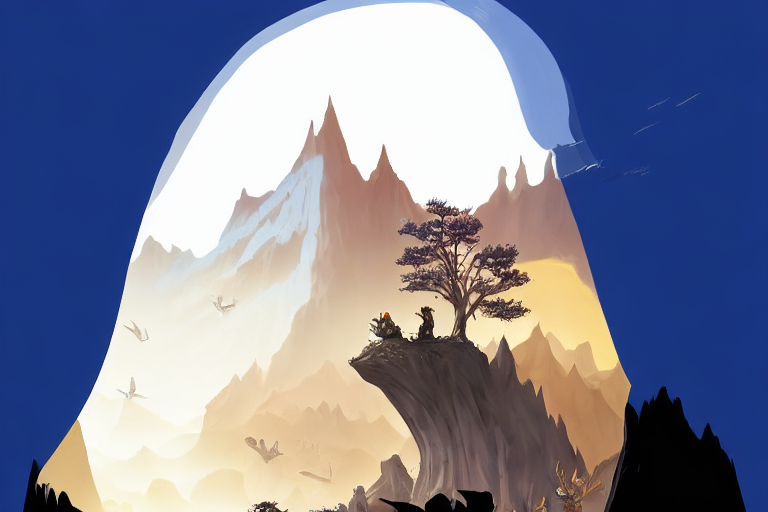

In [23]:
image[0]